### Mean-Variance Potfolio Optimization with Elastic Net Penalty


In [1]:
import pylops 
import numpy as np
import pandas as pd
import scipy.optimize
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix, csc_array
import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [261]:
equity_data=pd.read_csv('equity_data_2021.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=((equity_data/equity_data.shift(1))-1)*100
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.75
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.004241,0.601337,0.221121,1.564875,1.729961,0.461523,1.554968,-0.773264,1.879570,1.086302,...,1.870875,-0.627895,-1.083383,-0.669315,1.219336,-0.085784,1.986306,0.693214,-0.118346,0.459805
2018-01-04,1.307135,0.468493,-0.169719,-0.570285,1.751605,1.184084,-0.995244,1.684268,1.204158,0.955226,...,1.015085,0.781284,0.541465,-0.779117,0.667633,1.018032,1.975989,-0.144094,0.414690,0.596394
2018-01-05,0.779188,1.286385,0.289021,1.740796,1.540782,0.824909,2.644601,-0.667492,1.157076,-0.059136,...,0.641281,0.927731,0.667082,-0.700335,-0.187424,0.582802,1.557575,0.994065,0.039332,1.144357
2018-01-08,-0.324236,0.476265,-0.288188,-1.602218,2.708578,0.799134,0.391735,-0.223992,-0.161866,-0.304312,...,-0.538653,0.000000,-1.331389,0.748020,0.361115,0.169009,0.995067,0.190506,-0.491449,1.199560
2018-01-09,0.621379,-0.079000,0.170008,0.753845,0.943211,0.333489,-0.660355,0.324273,0.897105,0.695269,...,0.277391,-0.402941,0.677752,-1.166736,0.028780,-0.265126,3.064268,-1.608301,2.350854,1.171879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.304614,0.671383,0.837600,-0.019362,-0.210486,-0.054387,0.831393,0.182371,0.593665,0.782005,...,1.431850,1.195637,-0.789249,0.497589,0.521404,0.702313,-0.750507,0.181229,-0.390711,0.544257
2020-12-28,0.108871,0.252342,-0.516841,0.183997,3.131077,0.924992,0.516712,0.525894,-0.182046,0.028321,...,-1.827107,-0.305609,0.944140,1.067619,0.119703,2.082944,1.512373,-0.241208,0.046148,1.039073
2020-12-29,-0.492245,-1.636102,0.500975,1.208313,2.563034,-0.739365,-0.065621,-0.503018,0.633325,-0.985225,...,-0.072141,-1.694422,-1.004593,0.153090,-0.856830,-0.300603,-1.189259,2.391029,-1.360701,0.449532


### Computation of Naive mean and covariance estimation from sample

In [262]:
returns_mean=returns_train.mean().values
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

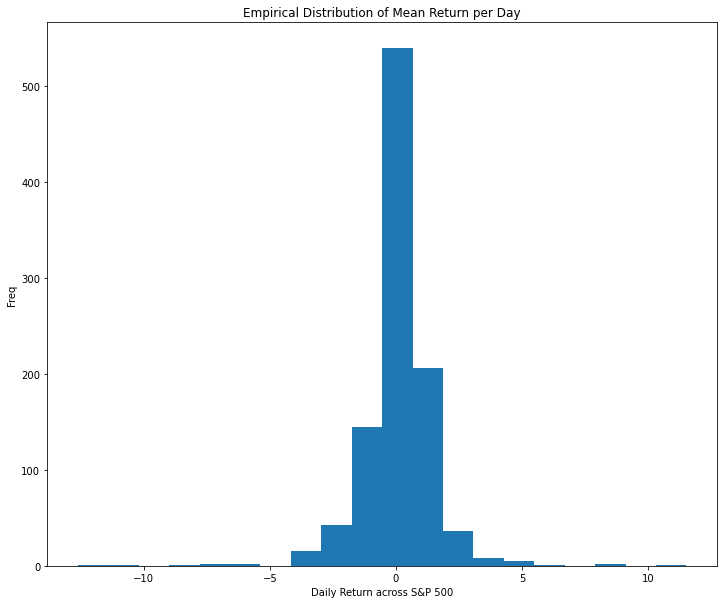

In [263]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

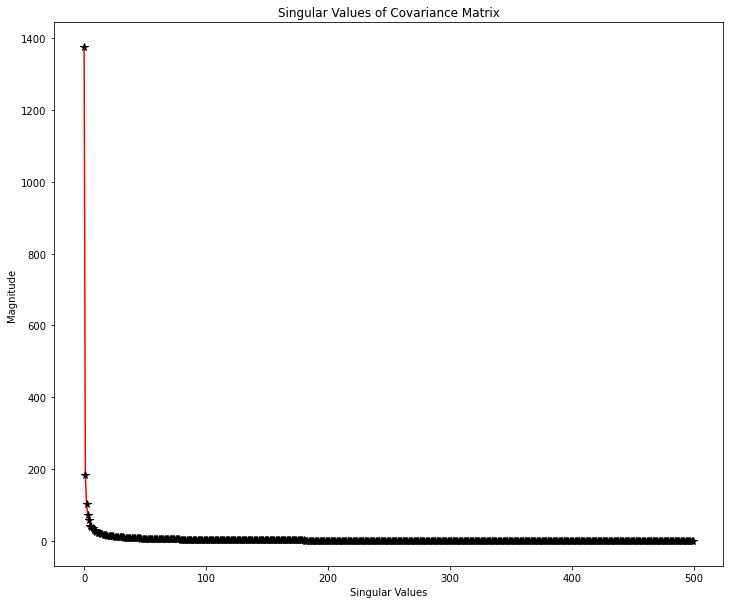

In [264]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Covariance and Mean Estimators

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via unconstrained minimization
    - Solve analytically via QPSolvers
- Applies shrinkage (L1) penalty within outer loop


In [304]:
def qp(cov,mean,w,d,b,beta,lambda1,tol,maxiter,approach):
    """ Inner optimization problem using unconstrained optimization 
        Approach 1 solves numerically via unconstrained minimization
        Approach 2 solves analytically via qpsolvers 
    """
    
    x0=w # initial guess is previous result
    
    if approach==1:
        # Numerical soln is much slower as unconstrained minimization
        def objective_val(w,cov,mean,d,b,beta,lambda1):
            """ MPT objective
            """

            obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)

            l2_pen=np.sum((d-beta*w-b)**2)

            return obj+lambda1*l2_pen/2

        res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda1),method='CG',options={'maxiter':25},tol=1e-12)
        w=res.x
        
    if approach==2:
        # analytical soln is very fast
        sparse_cov=csc_matrix(2*(cov+2*lambda1*np.identity(len(w))))
        mean=-1*mean
        w = solve_qp(sparse_cov,mean,initvals=x0, solver="osqp")
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  # elementwise max
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,beta=None,tol=1e-10,maxiter=100,approach=2):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            break
            
        
        if i%25==0 and i>0:
            print(f"{i}-th iteration with error of {error}")
        
        w_old=w
        w=qp(cov,mean,w_old,d,b,beta,lambda1,tol,maxiter,approach)
        error=np.sum((w-w_old)**2)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+w-d       
        i+=1
    
    
    print(f"Terminated in {i} iterations of error {error}")
    unit_w=w/np.linalg.norm(w,ord=1)
    return unit_w, error



### Numerical Results

- 10x magnitude on lambda1 param

In [319]:
lambda1=10e-4

w0,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 1.639508438409323e-11


Text(0, 0.5, 'Weight Allocation')

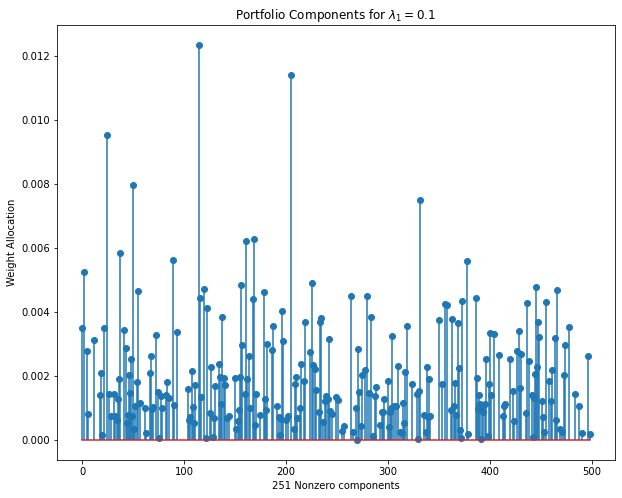

In [320]:
nonzero_w0=np.where(w0>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=0.1$")
ax.stem(nonzero_w0,w0[nonzero_w0])
plt.xlabel(f"{len(nonzero_w0)} Nonzero components")
plt.ylabel("Weight Allocation")

In [321]:
lambda1=10e-2
w1,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 1.134764965432072e-12


Text(0, 0.5, 'Weight Allocation')

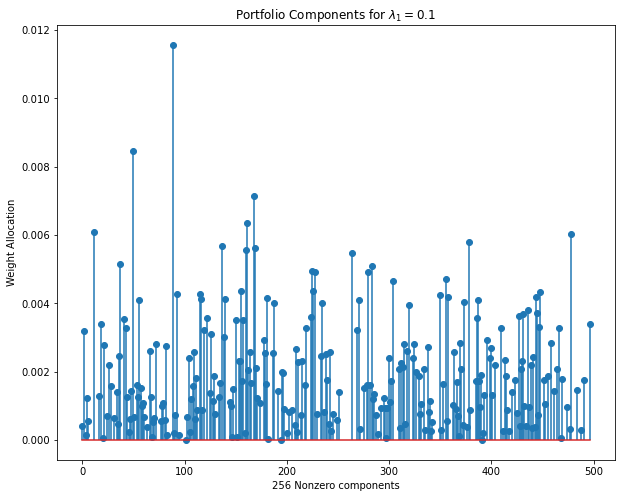

In [322]:
nonzero_w1=np.where(w1>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=0.1$")
ax.stem(nonzero_w1,w1[nonzero_w1])
plt.xlabel(f"{len(nonzero_w1)} Nonzero components")
plt.ylabel("Weight Allocation")

In [323]:
lambda1=10e2
w2,error2=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 1.6718699928894298e-18


Text(0, 0.5, 'Weight Allocation')

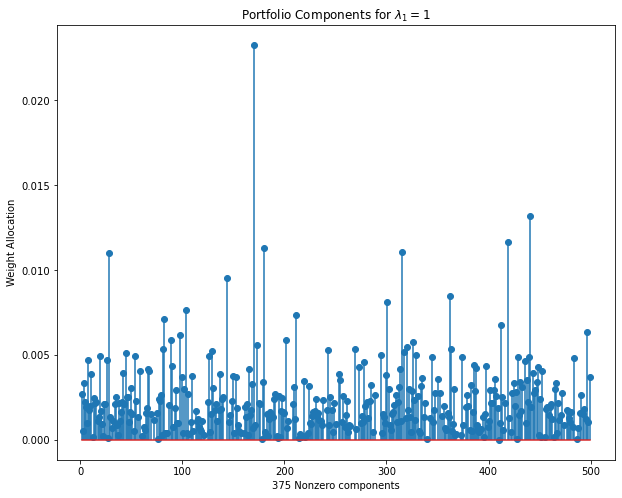

In [324]:
nonzero_w2=np.where(w2>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=1$")
ax.stem(nonzero_w2,w2[nonzero_w2])
plt.xlabel(f"{len(nonzero_w2)} Nonzero components")
plt.ylabel("Weight Allocation")


In [325]:
lambda1=10e4
w3,error3=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 1 iterations of error 2.85899199341e-11


Text(0, 0.5, 'Weight Allocation')

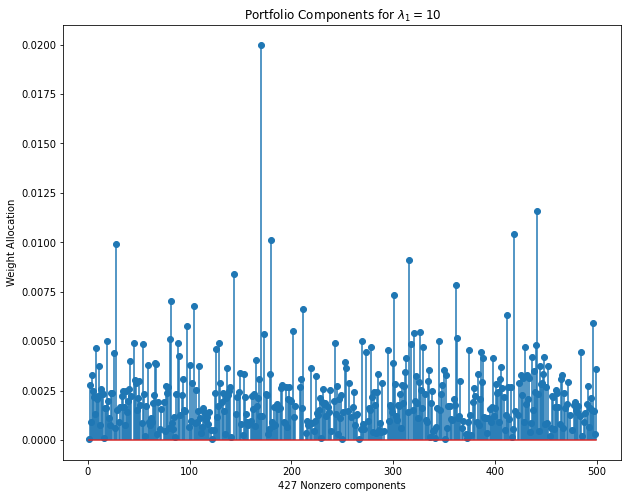

In [326]:
nonzero_w3=np.where(w3>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10$")
ax.stem(nonzero_w3,w3[nonzero_w3])
plt.xlabel(f"{len(nonzero_w3)} Nonzero components")
plt.ylabel("Weight Allocation")

### Grid Search Lambda Values 

In [327]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    results={}
    for i in params:
        w,error=split_bregman(returns_cov,returns_mean,lambda1=i,tol=1e-8,maxiter=25,approach=2)
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda_grid=np.logspace(-1,4,8)

sorted_dict=grid_search(lambda_grid,returns_mean,returns_cov)

Terminated in 2 iterations of error 1.134764965432072e-12
Terminated in 2 iterations of error 1.6162815695981137e-13
Terminated in 2 iterations of error 1.7775918516065775e-14
Terminated in 2 iterations of error 1.6444629535668663e-15
Terminated in 2 iterations of error 1.3888933451932309e-16
Terminated in 2 iterations of error 9.451186664317387e-18
Terminated in 2 iterations of error 5.063066335886468e-19
Terminated in 1 iterations of error 2.733798242601786e-09


Text(0, 0.5, 'Weight Allocation')

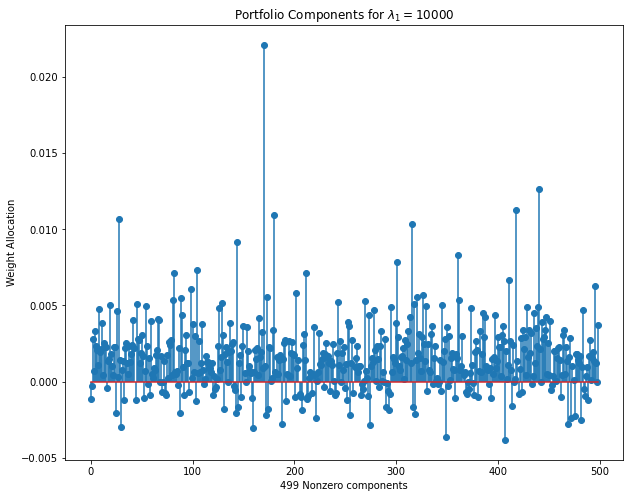

In [328]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10000$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [329]:
print(f"Largest Component is {max(wi[nonzero_wi])}")
print(f"Smallest Component is {min(wi[nonzero_wi])}")

Largest Component is 0.022123460248727633
Smallest Component is -0.003835354989702202


### Sharpe Ratio Performance 

In [316]:
returns_test

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-1.670575,-1.641739,-0.347061,-1.623890,-2.304134,-1.818460,-3.177164,-1.071218,-2.955291,-4.108962,...,-3.313080,-3.580349,-5.255695,-1.514916,-2.063070,-2.523948,-1.613192,-0.603541,-1.174029,-1.154081
2021-01-05,-0.168728,0.649114,1.237282,1.034054,1.853312,0.569298,0.878755,1.945060,0.072116,-0.278173,...,-0.834559,0.289542,3.077643,-0.974729,-0.120376,0.009452,0.645281,1.730216,1.583975,0.696864
2021-01-06,1.521157,3.445732,-0.208216,-0.863848,-0.306888,1.093353,-2.966151,4.051930,-3.990200,-0.350176,...,0.841583,0.585025,0.598962,2.214707,4.218135,0.548050,3.744383,2.849617,11.235950,1.469070
2021-01-07,-2.566164,1.229075,0.970697,1.070276,0.606328,0.943477,1.897725,-0.888471,2.451158,0.565820,...,0.760924,0.715058,-0.992331,-1.956057,4.538891,-0.761212,3.616838,-0.592825,3.050924,-0.089736
2021-01-08,-1.826541,-1.178958,0.278524,0.524785,0.154531,0.364738,1.817782,0.267022,1.540590,1.302930,...,-0.784410,-0.832483,-0.656038,0.920808,-1.014017,1.467806,-0.887315,-0.219706,-2.540509,0.664671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.988738,2.331763,1.652776,0.991816,1.595638,2.980335,0.445048,0.962710,1.414978,1.772724,...,1.099548,2.612277,-1.462641,0.315267,0.672341,1.972808,4.107080,0.645723,1.042331,1.649417
2021-12-28,0.531976,0.991740,-0.699848,-0.014883,-0.108986,-0.014446,1.864020,1.301651,-1.440245,-0.089320,...,-0.142222,0.914457,-1.278834,1.197251,1.039814,-0.021737,-1.485991,0.312966,0.158709,-0.916796
2021-12-29,0.433463,0.315638,0.512566,0.721781,1.230974,0.036127,0.734972,0.119531,-0.012296,0.788388,...,-0.121485,0.867783,-1.711769,0.502804,-0.133865,0.492831,0.636173,0.015599,0.538742,1.138178
